## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_cols(df, cols):
    return df[cols].T.values

def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

In [3]:
# new in this notebook:
def get_classification_duration(metadata):
    start = metadata.get('started_at')
#     start = metadata.get('subject_selection_state', {}).get('selected_at')  # don't use this. not accurate
    end = metadata.get('finished_at')
    
    timedelta = pd.Timestamp(end) - pd.Timestamp(start)
    
    return timedelta.total_seconds()

In [4]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [5]:
df['duration'] = df['metadata'].apply(lambda x: get_classification_duration(x))

## Analysis

In [6]:
groupby_user = df.groupby('user_name')

## no. of  classifications per user:

In [7]:
clas_per_user = groupby_user.agg('count')['Filename'].tolist()

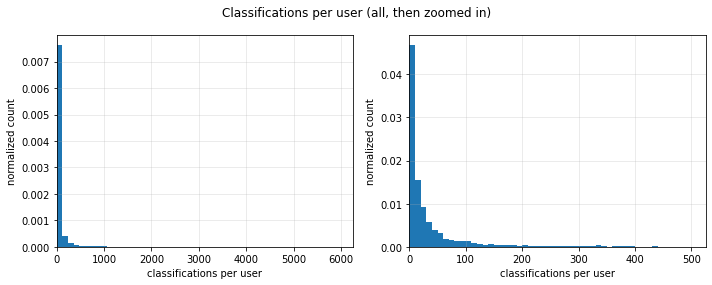

In [8]:
fig, fr = plt.subplots(1,2, figsize=(10,4))

kwargs = { "density": True, "bins": 50}

fr[0].hist(clas_per_user, **kwargs)
fr[1].hist(clas_per_user, **kwargs, range=[0,500])

for i in range(2):
    fr[i].set_ylabel('normalized count')
    fr[i].set_xlabel('classifications per user')
    fr[i].grid(alpha=0.3)
    fr[i].set_xlim(0)
    
fig.suptitle('Classifications per user (all, then zoomed in)')
fig.tight_layout()
plt.show()

## classification duration:

Plot histogram of classification durations (1) per classification, (2) per user, (3) per object.
Note that in reality, the tail of the distribution extends to ~1e5 for the per-classification and per-user cases, because there are some classifications that lasted over a day, presumably because someone simply left the page open and then finished the classification the next day.

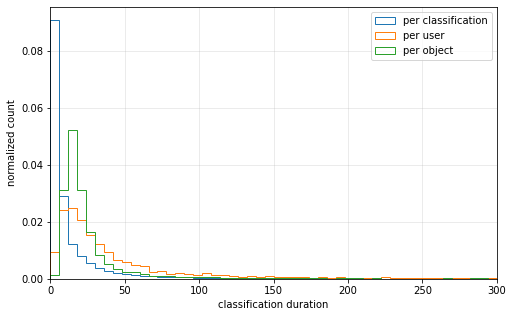

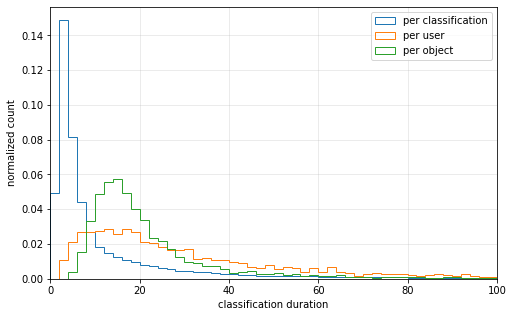

In [9]:
mean_duration_per_user = df[['user_name', 'duration']].groupby('user_name').agg('mean')['duration']

for displayrange in [[0,300], [0,100]]:
    fig, fr = plt.subplots(figsize=(8,5))

    kw = { "range": displayrange, "density": True, "histtype": "step", "bins": 50 }

    fr.hist(df['duration'], **kw, label='per classification')
    fr.hist(mean_duration_per_user, **kw, label='per user')
    fr.hist(df[['Filename', 'duration']].groupby('Filename').agg('mean')['duration'], **kw, label='per object')

    fr.set_xlim(displayrange)
    fr.grid(alpha=0.3)
    fr.set_xlabel('classification duration')
    fr.set_ylabel('normalized count')
    fr.legend()
    plt.show()

## Find a way to compare user performance to their peers:

In [20]:
tasks_hardcore = [0, 2, 1, 3, 4, 5, 9]
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

In [22]:
task_cols_list = [get_column_names(t, df_votes) for t in task_strings]

In [177]:
def get_consensus(row, task):
    votes = row[task]
    
    vals = np.array(list(votes.values()))
    keys = np.array(list(votes.keys()))

    if len(vals) > 0:
        consensus = list(keys[np.where(vals == np.max(vals))])
        return consensus    

In [166]:
for task in task_strings:
    df_votes['{} consensus'.format(task)] = df_votes.apply(lambda x: get_consensus(x, task), axis=1)

In [174]:
task = 'T0'

names, consensus = df_votes[['name', '{} consensus'.format(task)]].values.T
t0_consensus = {n: c for n, c in zip(names, consensus)}


In [181]:
task = 'T0'
df['with consensus {}'.format(task)] = df[['Filename', task]].apply(lambda x: x[task] in t0_consensus[x['Filename']] , axis=1)

In [184]:
groupby_user = df[['user_name', 'Filename', 'with consensus T0']].groupby('user_name')

_Note: I'm calling it accuracy in some places, but it's just consensus/precision among peers_

In [189]:
user_accuracy = {}

for name, group in groupby_user:
    cons = group['with consensus T0'].values.tolist()
    match = cons.count(True)/len(cons)
    no_match = cons.count(False)/len(cons)
    user_accuracy[name] = { "accuracy": match, "votes": len(cons)}

In [201]:
vote_count, accuracy = np.array([(v['votes'], v['accuracy']) for v in list(user_accuracy.values())]).T

## Plot votes per user vs. consensus (precision) among peers:

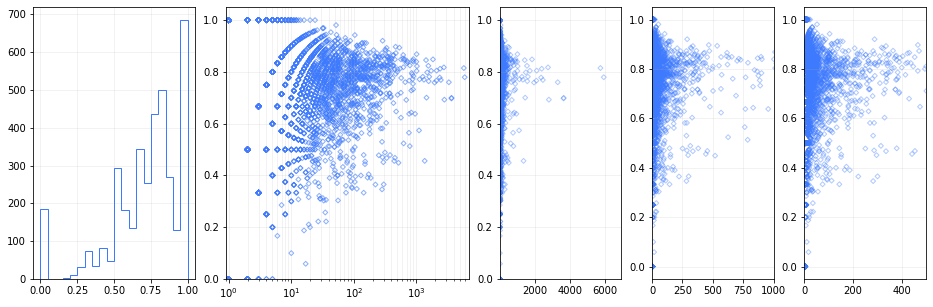

In [383]:
fig, fr = plt.subplots(1,5, figsize=(16,5), gridspec_kw={"wspace": 0.2, "width_ratios": [4,6,3,3,3]})

# c=np.log(vote_count), cmap='inferno_r'
fr[1].scatter(vote_count, accuracy, alpha=0.6, s=12,facecolor='none', edgecolor='xkcd:lightish blue', marker="D")  

for i in range (2,5):
    fr[i].scatter(vote_count, accuracy, alpha=0.4, s=12,facecolor='none', edgecolor='xkcd:lightish blue', marker="D")  

# fr[0].set_xlim(-10,)
fr[1].set_xscale('log')

fr[3].set_xlim(0, 1000)
fr[4].set_xlim(0,500)

for i in range(1,3):
    fr[i].set_xlim(0.9,max(vote_count)+1000)
    fr[i].set_ylim(0,)

# pick one:
# fr[0].barh(*np.unique(np.round(accuracy,1), return_counts=True), height=0.08, facecolor='xkcd:lightish blue', rasterized=False, align='center')
# fr[0].hist(accuracy, np.linspace(0,1,20), histtype="step", lw=3, edgecolor='xkcd:lightish blue', orientation='horizontal', align='left')

# fr[0].invert_xaxis()
# fr[0].set_axis_off()

fr[0].hist(accuracy, edgecolor='xkcd:lightish blue', bins=20, facecolor='none', histtype='step')
for i in range(5):
    fr[i].grid(alpha=0.2, which='both')

# fig.tight_layout()
plt.show()